# 0. Imports and Load Dataset

In [1]:
try:
    import dynamax
    import chex
    import flax
    from bayes_opt import BayesianOptimization
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    print('installing chex')
    %pip install chex
    print('installing flax')
    %pip install flax
    print('installing bayesopt')
    %pip install bayesian-optimization
    import dynamax
    import chex
    import flax
    from bayes_opt import BayesianOptimization

In [2]:
from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import jacrev
from jax import vmap
import flax.linen as nn
from jax.flatten_util import ravel_pytree
from tensorflow_probability.substrates.jax.distributions import Normal

from dynamax.utils.datasets import load_1d_synthetic_dataset
from dynamax.rebayes.ekf import RebayesEKF
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM

/Users/peterchang/Desktop/Repos/transformers_private-2/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
(X_train, y_train), (X_test, y_test) = load_1d_synthetic_dataset(n_train=100, n_test=200)
X_train, y_train, X_test, y_test = X_train.squeeze(), y_train.squeeze(), X_test.squeeze(), y_test.squeeze()
shuffle_indx = jr.permutation(jr.PRNGKey(0), jnp.arange(X_train.shape[0]))
X_train_shuffled, y_train_shuffled = X_train[shuffle_indx], y_train[shuffle_indx]
x_grid = jnp.linspace(-0.2, 0.8, 500)

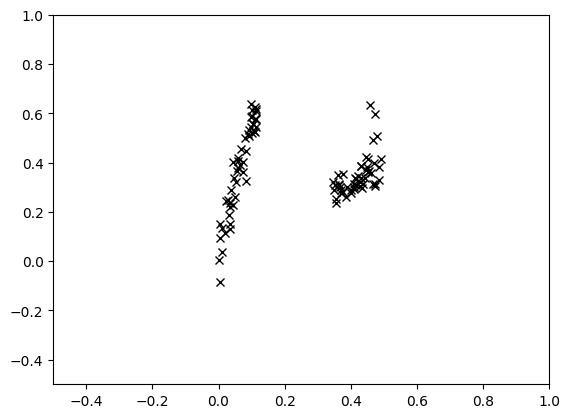

In [4]:
fig, ax = plt.subplots()
ax.plot(X_train, y_train, 'kx', label='data')
ax.set_xlim(-0.5, 1.0)
ax.set_ylim(-0.5, 1.0);

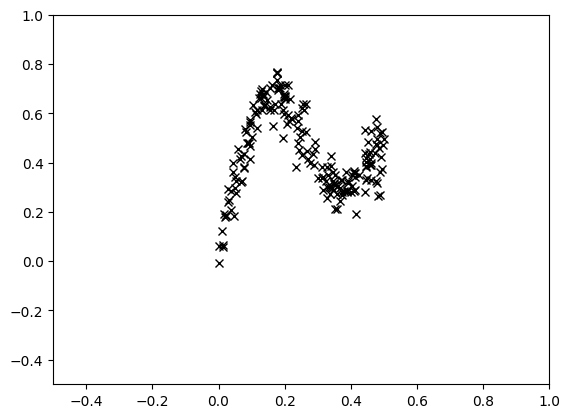

In [5]:
fig, ax = plt.subplots()
ax.plot(X_test, y_test, 'kx', label='data')
ax.set_xlim(-0.5, 1.0)
ax.set_ylim(-0.5, 1.0);

# 1. EKF Models

In [6]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

def get_mlp_flattened_params(model_dims, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    flat_params, unflatten_fn = ravel_pytree(params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

In [7]:
def mean_cov_callback(bel, t, x, y):
    return bel.mean, bel.cov

def run_ekf(X, Y, ekf_params, type='fcekf', callback=mean_cov_callback):
    estimator = RebayesEKF(ekf_params, method = type)
    _, filtered_means = estimator.scan(X, Y, callback=callback)

    return filtered_means

# 2. Posterior Predictive Computation

In [8]:
def linearized_posterior_predictive_moments_diagonal(apply_fn, x_to_pred, post_mean, post_cov, obs_noise=0.0):
    """Compute posterior predictive moments for a single input x_to_pred"""
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    pred_cov = (F * post_cov) @ F.T + obs_noise

    return pred_mean, pred_cov

In [9]:
def linearized_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_cov, obs_noise=0.0):
    """Compute posterior predictive moments for a single input x_to_pred"""
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    pred_cov = F @ post_cov @ F.T + obs_noise

    return pred_mean, pred_cov


In [39]:
def plot_predictions(X_train, y_train, X_eval, initial_var, emission_var, 
                     flat_params, apply_fn, ekf_type='fcekf'):
    state_dim = flat_params.size
    ekf_params = ParamsGGSSM(
        initial_mean=flat_params,
        initial_covariance=jnp.eye(state_dim) * initial_var,
        dynamics_function=lambda w, _: w,
        dynamics_covariance = jnp.eye(state_dim) * 0,
        emission_mean_function = lambda w, x: apply_fn(w, x),
        emission_cov_function = lambda w, x: jnp.array([emission_var]),
    )
    # Train EKF
    ekf_post = run_ekf(X_train, y_train, ekf_params, type=ekf_type)
    ekf_mean, ekf_cov = ekf_post[0][-1], ekf_post[1][-1]

    # Predict
    if len(ekf_cov.shape) == 2:
        posterior_predictive_fn = linearized_posterior_predictive_moments
    else:
        posterior_predictive_fn = linearized_posterior_predictive_moments_diagonal
    pred_means, pred_covs = vmap(
        posterior_predictive_fn, (None, 0, None, None, None)
    )(apply_fn, X_eval, ekf_mean, ekf_cov, emission_var)
    pred_means, pred_covs = pred_means.squeeze(), pred_covs.squeeze()

    # Plot predictions
    fig, ax = plt.subplots()
    ax.plot(X_eval, pred_means, label='mean');
    ax.plot(X_train, y_train, 'kx', label='data', alpha=0.8);
    ax.fill_between(X_eval.squeeze(), pred_means - 2.0 * jnp.sqrt(pred_covs), pred_means + 2.0 * jnp.sqrt(pred_covs), alpha=0.5, label='1 std');
    ax.set_xlim(-0.2, 0.7)
    ax.set_ylim(-1.0, 1.5)
    ax.set_title(f'{ekf_type.upper()} predictions')

# 3. Hyperparameter Tuning

In [11]:
# Define the MLP model
input_dim, hidden_dims, output_dim = 1, [50,], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)
print(flat_params.shape)

(151,)


In [12]:
# Helper funciton for Bayesopt hyperparameter tuning
def evaluate_inference(init_params, apply_fn, inference_fn, X_train, y_train, X_test, y_test, initial_var, emission_var):
    state_dim = init_params.size
    ekf_params = ParamsGGSSM(
        initial_mean=init_params,
        initial_covariance=jnp.eye(state_dim) * initial_var,
        dynamics_function=lambda w, _: w,
        dynamics_covariance = jnp.eye(state_dim) * 0,
        emission_mean_function = lambda w, x: apply_fn(w, x),
        emission_cov_function = lambda w, x: jnp.array([emission_var])
    )
    posterior = inference_fn(X_train, y_train, ekf_params)
    post_mean, post_cov = posterior[0][-1], posterior[1][-1]
    if len(post_cov.shape) < 2:
        posterior_predictive_fn = lambda x, m, c: linearized_posterior_predictive_moments_diagonal(apply_fn, x, m, c, emission_var)
    else:
        posterior_predictive_fn = lambda x, m, c: linearized_posterior_predictive_moments(apply_fn, x, m, c, emission_var)

    def ll(x, y, post_mean, post_cov):
        y_pred, pred_cov = posterior_predictive_fn(x, post_mean, post_cov)
        N = Normal(
            loc=y_pred,
            scale=pred_cov,
        )
        return N.log_prob(y)
    lls = vmap(ll, (0, 0, None, None))(X_test, y_test, post_mean, post_cov).squeeze()
    result = lls.sum()
    if jnp.isnan(result) or jnp.isinf(result):
        result = -1e10
    return result

fcekf_inference = lambda X, y, params: run_ekf(X, y, params, type='fcekf')
fdekf_inference = lambda X, y, params: run_ekf(X, y, params, type='fdekf')
vdekf_inference = lambda X, y, params: run_ekf(X, y, params, type='vdekf')

# 4. Single-Pass

## 4.1 Unshuffled

In [428]:
# Hyperparameter tuning
evaluate_fcekf = lambda initial_var, emission_var: evaluate_inference(
    flat_params, apply_fn, fcekf_inference, X_train, y_train, X_test, y_test, initial_var, emission_var
)
evaluate_fdekf = lambda initial_var, emission_var: evaluate_inference(
    flat_params, apply_fn, fdekf_inference, X_train, y_train, X_test, y_test, initial_var, emission_var
)
evaluate_vdekf = lambda initial_var, emission_var: evaluate_inference(
    flat_params, apply_fn, vdekf_inference, X_train, y_train, X_test, y_test, initial_var, emission_var
)

params_opt = {
    'initial_var': (1e-6, 5.0),
    'emission_var': (1e-6, 1.0)
}

# Tune FDEKF params
fcekf_optimizer = BayesianOptimization(evaluate_fcekf, params_opt, random_state=0)
fcekf_optimizer.maximize(init_points=200, n_iter=200)
print(fcekf_optimizer.max)

|   iter    |  target   | emissi... | initia... |
-------------------------------------------------
| 1         | -0.5143   | 0.5488    | 3.576     |
| 2         | -0.5545   | 0.6028    | 2.724     |
| 3         | -0.3272   | 0.4237    | 3.229     |
| 4         | -0.3702   | 0.4376    | 4.459     |
| 5         | -0.9398   | 0.9637    | 1.917     |
| 6         | -0.7768   | 0.7917    | 2.644     |
| 7         | -0.5777   | 0.568     | 4.628     |
| 8         | -3.095    | 0.07104   | 0.4356    |
| 9         | -0.4574   | 0.02022   | 4.163     |
| 10        | -0.8034   | 0.7782    | 4.35      |
| 11        | -0.9871   | 0.9786    | 3.996     |
| 12        | -0.4081   | 0.4615    | 3.903     |
| 13        | 0.4148    | 0.1183    | 3.2       |
| 14        | 0.1566    | 0.1434    | 4.723     |
| 15        | -0.4248   | 0.5218    | 2.073     |
| 16        | -0.07488  | 0.2646    | 3.871     |
| 17        | -0.3585   | 0.4562    | 2.842     |
| 18        | -0.06855  | 0.01879   | 3.088     |


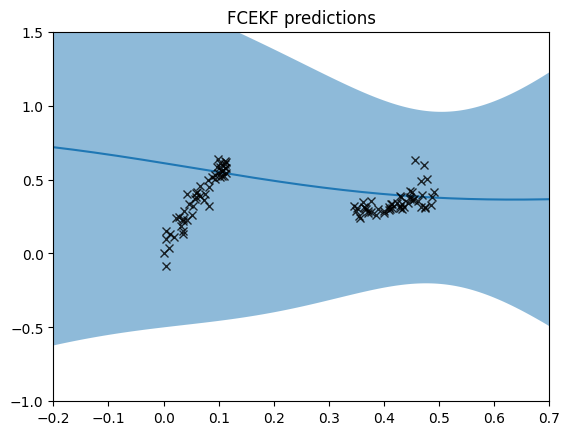

In [433]:
# FCEKF
plot_predictions(X_train, y_train, x_grid, 2.428138494045519, 0.063956202165715, flat_params, apply_fn);

In [429]:
# Tune FDEKF params
fdekf_optimizer = BayesianOptimization(evaluate_fdekf, params_opt, random_state=0)
fdekf_optimizer.maximize(init_points=200, n_iter=200)
print(fdekf_optimizer.max)

|   iter    |  target   | emissi... | initia... |
-------------------------------------------------
| 1         | -2.448    | 0.5488    | 3.576     |
| 2         | -2.267    | 0.6028    | 2.724     |
| 3         | -2.313    | 0.4237    | 3.229     |
| 4         | -2.583    | 0.4376    | 4.459     |
| 5         | -2.202    | 0.9637    | 1.917     |
| 6         | -2.329    | 0.7917    | 2.644     |
| 7         | -2.659    | 0.568     | 4.628     |
| 8         | -0.448    | 0.07104   | 0.4356    |
| 9         | -2.339    | 0.02022   | 4.163     |
| 10        | -2.679    | 0.7782    | 4.35      |
| 11        | -2.678    | 0.9786    | 3.996     |
| 12        | -2.482    | 0.4615    | 3.903     |
| 13        | -2.143    | 0.1183    | 3.2       |
| 14        | -2.518    | 0.1434    | 4.723     |
| 15        | -2.032    | 0.5218    | 2.073     |
| 16        | -2.391    | 0.2646    | 3.871     |
| 17        | -2.229    | 0.4562    | 2.842     |
| 18        | -2.045    | 0.01879   | 3.088     |


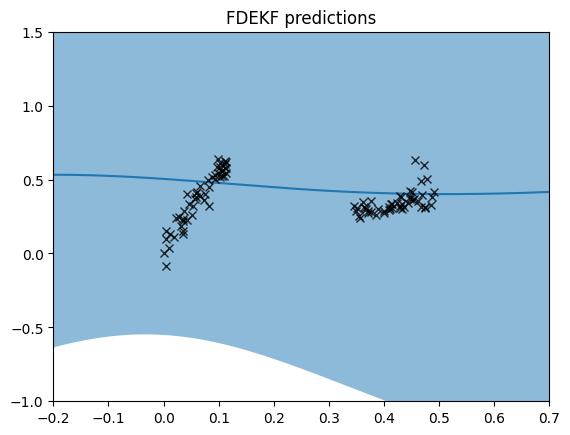

In [432]:
# FDEKF
plot_predictions(X_train, y_train, x_grid, 0.0926099537812754, 0.19999732489987518, flat_params, apply_fn, 'fdekf');

In [430]:
# Tune VDEKF params
vdekf_optimizer = BayesianOptimization(evaluate_vdekf, params_opt, random_state=0)
vdekf_optimizer.maximize(init_points=200, n_iter=200)
print(vdekf_optimizer.max)

|   iter    |  target   | emissi... | initia... |
-------------------------------------------------
| 1         | -14.76    | 0.5488    | 3.576     |
| 2         | -1.038    | 0.6028    | 2.724     |
| 3         | -3.404    | 0.4237    | 3.229     |
| 4         | -80.21    | 0.4376    | 4.459     |
| 5         | -9.946    | 0.9637    | 1.917     |
| 6         | -3.614    | 0.7917    | 2.644     |
| 7         | -233.7    | 0.568     | 4.628     |
| 8         | -7.649e+0 | 0.07104   | 0.4356    |
| 9         | -5.532e+0 | 0.02022   | 4.163     |
| 10        | -1.202e+0 | 0.7782    | 4.35      |
| 11        | -1.439    | 0.9786    | 3.996     |
| 12        | -1.735e+0 | 0.4615    | 3.903     |
| 13        | -1.527e+0 | 0.1183    | 3.2       |
| 14        | -4.073e+0 | 0.1434    | 4.723     |
| 15        | -19.64    | 0.5218    | 2.073     |
| 16        | -4.789e+0 | 0.2646    | 3.871     |
| 17        | -429.7    | 0.4562    | 2.842     |
| 18        | -1.852e+0 | 0.01879   | 3.088     |


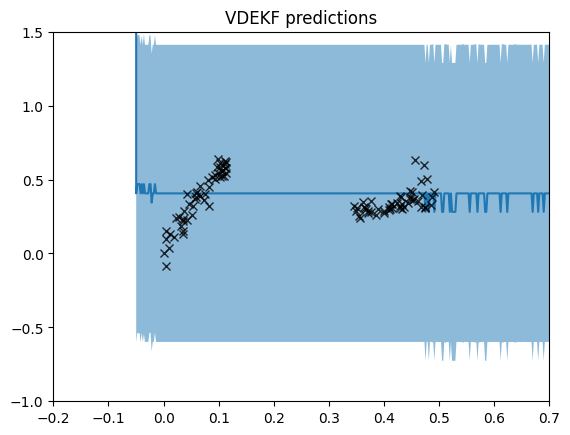

In [431]:
# VDEKF
plot_predictions(X_train, y_train, x_grid, 0.6433762525273097, 0.16403713066572215, flat_params, apply_fn, 'vdekf');

## 4.2 Shuffled

In [440]:
# Hyperparameter tuning
evaluate_fcekf = lambda initial_var, emission_var: evaluate_inference(
    flat_params, apply_fn, fcekf_inference, X_train_shuffled, y_train_shuffled, X_test, y_test, initial_var, emission_var
)
evaluate_fdekf = lambda initial_var, emission_var: evaluate_inference(
    flat_params, apply_fn, fdekf_inference, X_train_shuffled, y_train_shuffled, X_test, y_test, initial_var, emission_var
)
evaluate_vdekf = lambda initial_var, emission_var: evaluate_inference(
    flat_params, apply_fn, vdekf_inference, X_train_shuffled, y_train_shuffled, X_test, y_test, initial_var, emission_var
)

params_opt = {
    'initial_var': (1e-6, 5.0),
    'emission_var': (1e-6, 1.0)
}

# Tune FCEKF params
fcekf_optimizer = BayesianOptimization(evaluate_fcekf, params_opt, random_state=0)
fcekf_optimizer.maximize(init_points=200, n_iter=200)
print(fcekf_optimizer.max)

|   iter    |  target   | emissi... | initia... |
-------------------------------------------------
| 1         | -0.5821   | 0.5488    | 3.576     |
| 2         | -0.5961   | 0.6028    | 2.724     |
| 3         | -0.3512   | 0.4237    | 3.229     |
| 4         | -0.3667   | 0.4376    | 4.459     |
| 5         | -0.9525   | 0.9637    | 1.917     |
| 6         | -0.8181   | 0.7917    | 2.644     |
| 7         | -0.5952   | 0.568     | 4.628     |
| 8         | -1.541    | 0.07104   | 0.4356    |
| 9         | -0.223    | 0.02022   | 4.163     |
| 10        | -0.9041   | 0.7782    | 4.35      |
| 11        | -1.042    | 0.9786    | 3.996     |
| 12        | -0.4144   | 0.4615    | 3.903     |
| 13        | 0.02323   | 0.1183    | 3.2       |
| 14        | -0.02144  | 0.1434    | 4.723     |
| 15        | -0.4499   | 0.5218    | 2.073     |
| 16        | -0.03918  | 0.2646    | 3.871     |
| 17        | -0.4217   | 0.4562    | 2.842     |
| 18        | 0.2497    | 0.01879   | 3.088     |


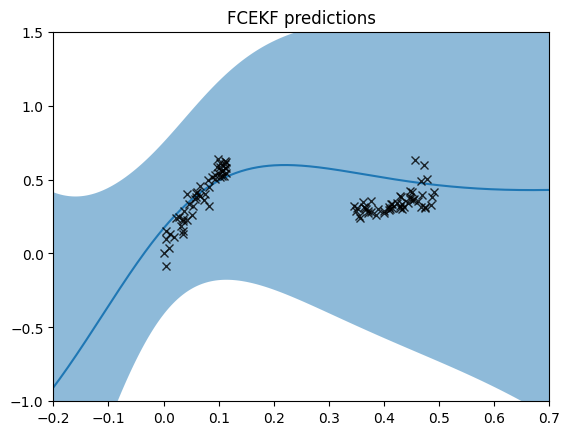

In [457]:
# FCEKF
plot_predictions(X_train_shuffled, y_train_shuffled, x_grid, 3.31165455284946, 0.006383963074997111, flat_params, apply_fn);

In [442]:
# Tune FDEKF params
fdekf_optimizer = BayesianOptimization(evaluate_fdekf, params_opt, random_state=0)
fdekf_optimizer.maximize(init_points=200, n_iter=200)
print(fdekf_optimizer.max)

|   iter    |  target   | emissi... | initia... |
-------------------------------------------------
| 1         | -1.848    | 0.5488    | 3.576     |
| 2         | -1.821    | 0.6028    | 2.724     |
| 3         | -1.652    | 0.4237    | 3.229     |
| 4         | -1.796    | 0.4376    | 4.459     |
| 5         | -2.0      | 0.9637    | 1.917     |
| 6         | -1.988    | 0.7917    | 2.644     |
| 7         | -1.96     | 0.568     | 4.628     |
| 8         | -0.5575   | 0.07104   | 0.4356    |
| 9         | -1.249    | 0.02022   | 4.163     |
| 10        | -2.141    | 0.7782    | 4.35      |
| 11        | -2.265    | 0.9786    | 3.996     |
| 12        | -1.772    | 0.4615    | 3.903     |
| 13        | -1.138    | 0.1183    | 3.2       |
| 14        | -1.332    | 0.1434    | 4.723     |
| 15        | -1.639    | 0.5218    | 2.073     |
| 16        | -1.514    | 0.2646    | 3.871     |
| 17        | -1.655    | 0.4562    | 2.842     |
| 18        | -1.028    | 0.01879   | 3.088     |


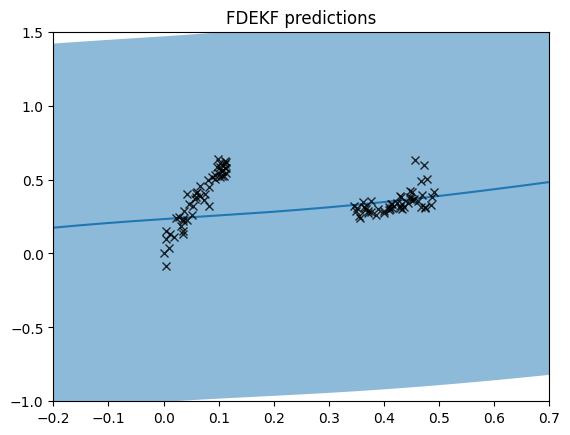

In [446]:
# FDEKF
plot_predictions(X_train_shuffled, y_train_shuffled, x_grid, 0.0032995789145403623, 0.37619338006618136, flat_params, apply_fn, 'fdekf');

In [443]:
# Tune VDEKF params
vdekf_optimizer = BayesianOptimization(evaluate_vdekf, params_opt, random_state=0)
vdekf_optimizer.maximize(init_points=200, n_iter=200)
print(vdekf_optimizer.max)

|   iter    |  target   | emissi... | initia... |
-------------------------------------------------
| 1         | -716.4    | 0.5488    | 3.576     |
| 2         | -6.04e+05 | 0.6028    | 2.724     |
| 3         | -3.859e+0 | 0.4237    | 3.229     |
| 4         | -0.5977   | 0.4376    | 4.459     |
| 5         | -1.329    | 0.9637    | 1.917     |
| 6         | -5.615    | 0.7917    | 2.644     |
| 7         | -3.521e+0 | 0.568     | 4.628     |
| 8         | -8.471e+0 | 0.07104   | 0.4356    |
| 9         | -6.251e+0 | 0.02022   | 4.163     |
| 10        | -9.824e+1 | 0.7782    | 4.35      |
| 11        | -1.58     | 0.9786    | 3.996     |
| 12        | -13.54    | 0.4615    | 3.903     |
| 13        | -196.0    | 0.1183    | 3.2       |
| 14        | -23.26    | 0.1434    | 4.723     |
| 15        | -1.595    | 0.5218    | 2.073     |
| 16        | -0.2457   | 0.2646    | 3.871     |
| 17        | -3.851e+0 | 0.4562    | 2.842     |
| 18        | -2.402e+0 | 0.01879   | 3.088     |


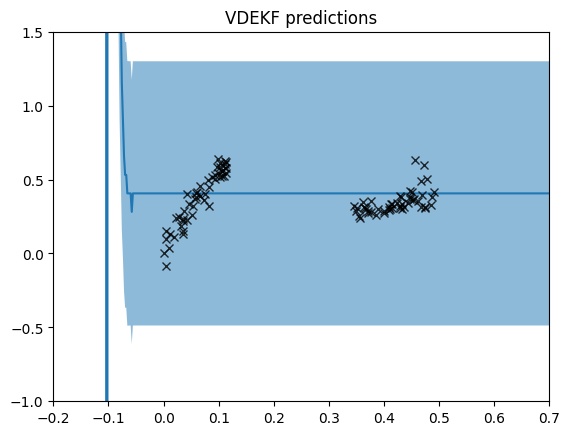

In [447]:
# VDEKF
plot_predictions(X_train_shuffled, y_train_shuffled, x_grid, 3.7571607723698373, 0.1315544453739281, flat_params, apply_fn, 'vdekf');

# 5. Full-Batch (10 Batches)

In [318]:
num_batches = 10

# Unshuffled data
X_train_10 = jnp.array([X_train] * num_batches).ravel()
y_train_10 = jnp.array([y_train] * num_batches).ravel()

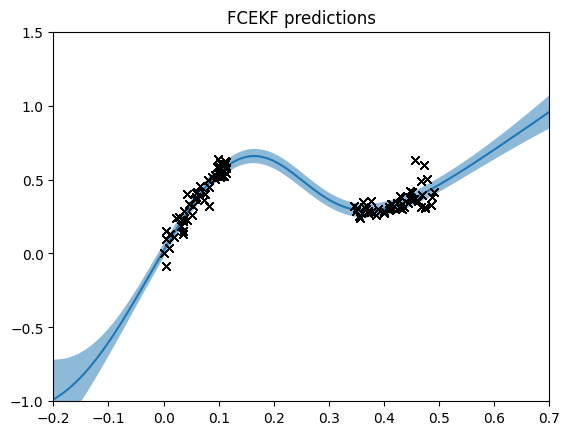

In [449]:
plot_predictions(X_train_10, y_train_10, x_grid, 1.0, 5e-4, flat_params, apply_fn);

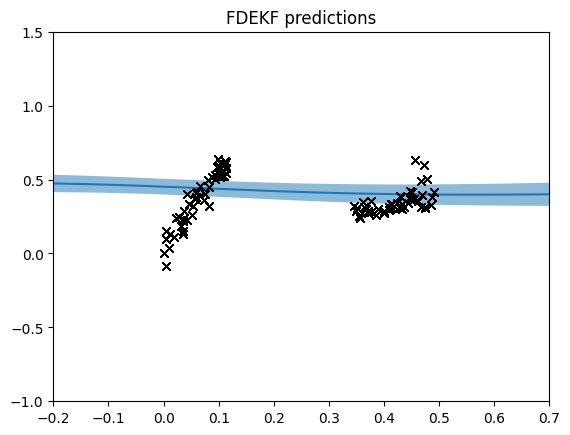

In [325]:
plot_predictions(X_train_10, y_train_10, x_grid, 1.0, 5e-4, flat_params, apply_fn, 'fdekf');

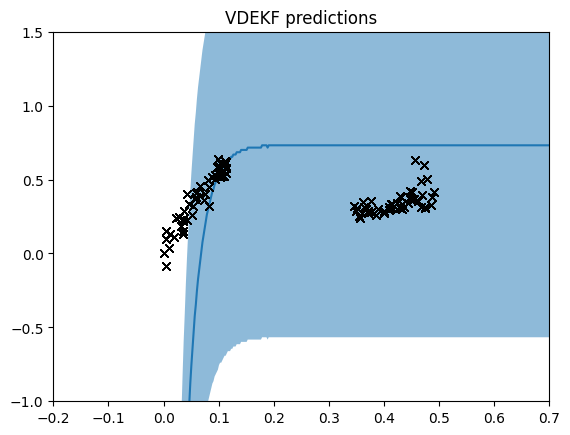

In [364]:
plot_predictions(X_train_10, y_train_10, x_grid, 1.0, 4e-1, flat_params, apply_fn, 'vdekf');

# 6. "Mini"-Batch (10 Batches)

In [267]:
num_batches = 10

X_train_mini_left, X_train_mini_right = X_train[:len(X_train)//2], X_train[len(X_train)//2:]
y_train_mini_left, y_train_mini_right = y_train[:len(y_train)//2], y_train[len(y_train)//2:]
X_train_mini_left_10 = jnp.array([X_train_mini_left] * num_batches).ravel()
y_train_mini_left_10 = jnp.array([y_train_mini_left] * num_batches).ravel()
X_train_mini_right_10 = jnp.array([X_train_mini_right] * num_batches).ravel()
y_train_mini_right_10 = jnp.array([y_train_mini_right] * num_batches).ravel()

X_train_mini_10 = jnp.concatenate([X_train_mini_left_10, X_train_mini_right_10])
y_train_mini_10 = jnp.concatenate([y_train_mini_left_10, y_train_mini_right_10])

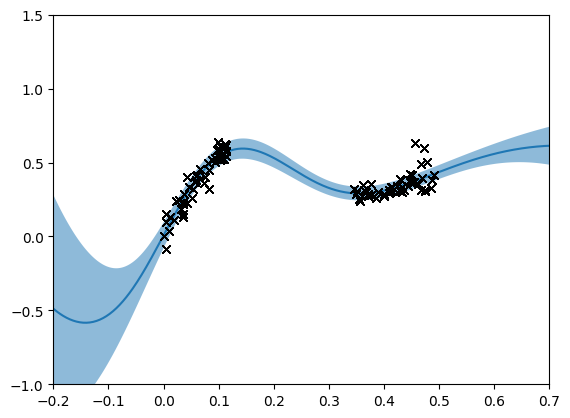

In [270]:
plot_predictions(X_train_mini_10, y_train_mini_10, x_grid, 6.0, 5e-4, flat_params, apply_fn);

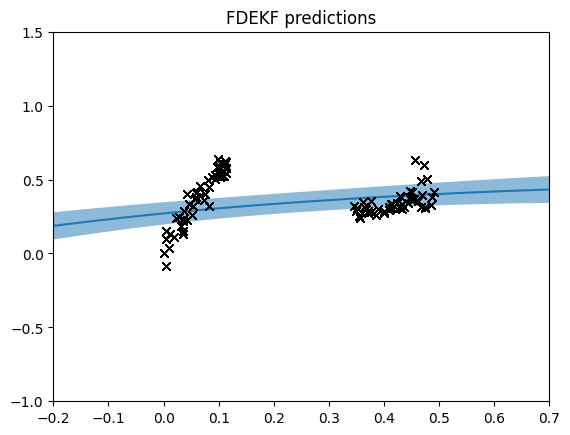

In [366]:
plot_predictions(X_train_mini_10, y_train_mini_10, x_grid, 1.0, 5e-4, flat_params, apply_fn, 'fdekf');

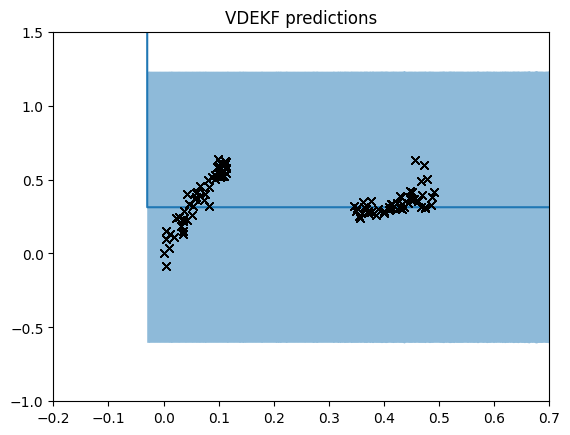

In [382]:
plot_predictions(X_train_mini_10, y_train_mini_10, x_grid, 1.0, 2e-1, flat_params, apply_fn, 'vdekf');

# 7. Full-Batch (100 Batches)

In [253]:
num_batches = 100

# Unshuffled data
X_train_100 = jnp.array([X_train] * num_batches).ravel()
y_train_100 = jnp.array([y_train] * num_batches).ravel()

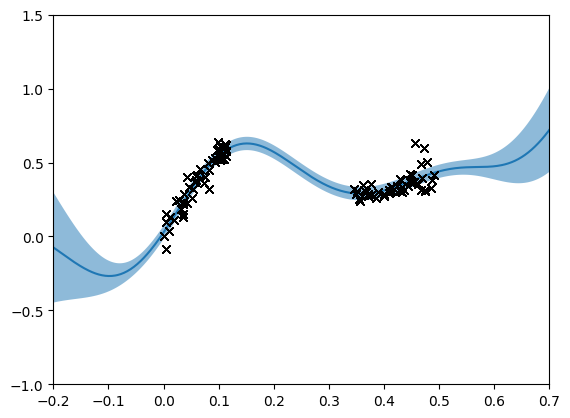

In [259]:
plot_predictions(X_train_100, y_train_100, x_grid, 6.0, 5e-4, flat_params, apply_fn);

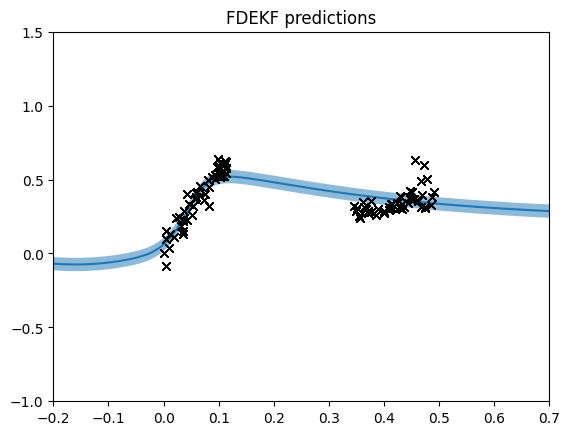

In [388]:
plot_predictions(X_train_100, y_train_100, x_grid, 6.0, 5e-4, flat_params, apply_fn, 'fdekf');

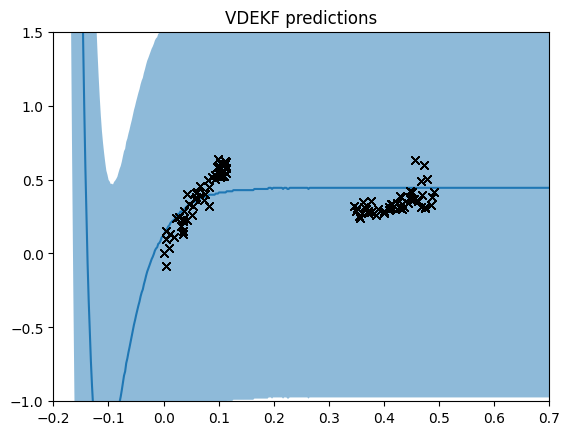

In [413]:
plot_predictions(X_train_100, y_train_100, x_grid, 1.0, 0.5, flat_params, apply_fn, 'vdekf');

# 8. "Mini"-Batch (100 Batches)

In [271]:
num_batches = 100

X_train_mini_left, X_train_mini_right = X_train[:len(X_train)//2], X_train[len(X_train)//2:]
y_train_mini_left, y_train_mini_right = y_train[:len(y_train)//2], y_train[len(y_train)//2:]
X_train_mini_left_100 = jnp.array([X_train_mini_left] * num_batches).ravel()
y_train_mini_left_100 = jnp.array([y_train_mini_left] * num_batches).ravel()
X_train_mini_right_100 = jnp.array([X_train_mini_right] * num_batches).ravel()
y_train_mini_right_100 = jnp.array([y_train_mini_right] * num_batches).ravel()

X_train_mini_100 = jnp.concatenate([X_train_mini_left_10, X_train_mini_right_10])
y_train_mini_100 = jnp.concatenate([y_train_mini_left_10, y_train_mini_right_10])

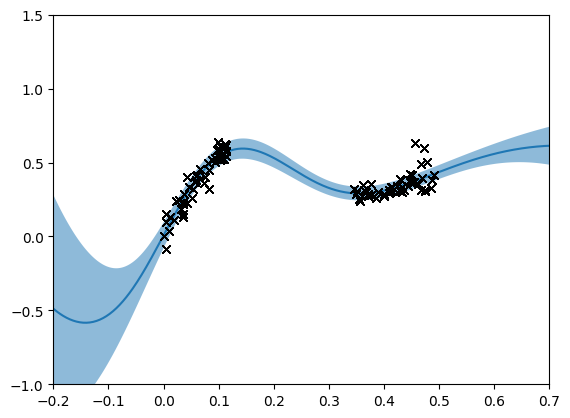

In [272]:
plot_predictions(X_train_mini_100, y_train_mini_100, x_grid, 6.0, 5e-4, flat_params, apply_fn);

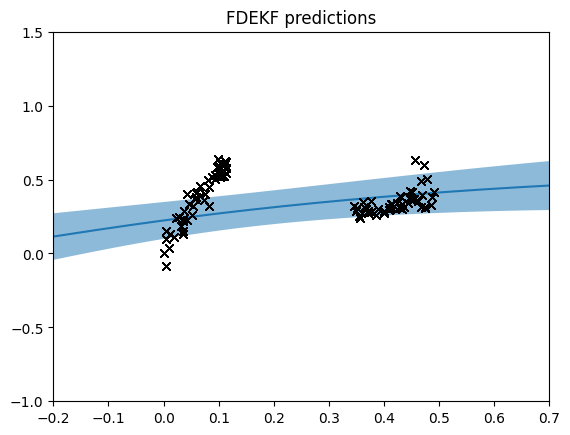

In [417]:
plot_predictions(X_train_mini_100, y_train_mini_100, x_grid, 6.0, 5e-4, flat_params, apply_fn, 'fdekf');

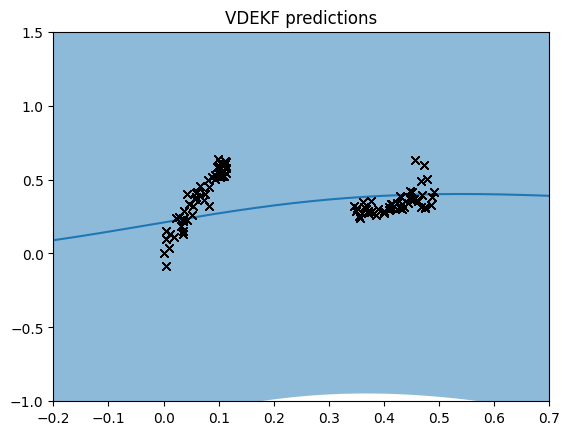

In [423]:
plot_predictions(X_train_mini_100, y_train_mini_100, x_grid, 1.0, 0.4, flat_params, apply_fn, 'vdekf');

# Dataset with a Bigger Gap Between the Two Subsets

In [13]:
def load_1d_synthetic_dataset(n_train=200, n_test=100, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key1, key2, subkey1, subkey2 = jr.split(key, 4)

    X_train = jr.uniform(key1, shape=(2*n_train, 1), minval=-1.0, maxval=1.0)
    X_test = jr.uniform(key2, shape=(n_test, 1), minval=-1.0, maxval=1.0)
    
    def generating_function(key, x):
        epsilon = jr.normal(key)*0.1
        return -jnp.sin(3/2 * jnp.pi*x) + epsilon
    
    keys_train = jr.split(subkey1, X_train.shape[0])
    keys_test = jr.split(subkey2, X_test.shape[0])
    y_train = vmap(generating_function)(keys_train, X_train)
    y_test = vmap(generating_function)(keys_test, X_test)

    sorted_idx = jnp.argsort(X_train.squeeze())
    left_threshold = int(n_train * 1/3)
    train_idx = jnp.concatenate([
        sorted_idx[:left_threshold], sorted_idx[left_threshold + n_train:]
    ])

    X_train, y_train = X_train[train_idx], y_train[train_idx]

    return (X_train, y_train), (X_test, y_test)

In [57]:
def plot_predictions(X_train, y_train, X_eval, initial_var, emission_var, 
                     flat_params, apply_fn, ekf_type='fcekf'):
    state_dim = flat_params.size
    ekf_params = ParamsGGSSM(
        initial_mean=flat_params,
        initial_covariance=jnp.eye(state_dim) * initial_var,
        dynamics_function=lambda w, _: w,
        dynamics_covariance = jnp.eye(state_dim) * 0,
        emission_mean_function = lambda w, x: apply_fn(w, x),
        emission_cov_function = lambda w, x: jnp.array([emission_var]),
    )
    # Train EKF
    ekf_post = run_ekf(X_train, y_train, ekf_params, type=ekf_type)
    ekf_mean, ekf_cov = ekf_post[0][-1], ekf_post[1][-1]

    # Predict
    if len(ekf_cov.shape) == 2:
        posterior_predictive_fn = linearized_posterior_predictive_moments
    else:
        posterior_predictive_fn = linearized_posterior_predictive_moments_diagonal
    pred_means, pred_covs = vmap(
        posterior_predictive_fn, (None, 0, None, None, None)
    )(apply_fn, X_eval, ekf_mean, ekf_cov, emission_var)
    pred_means, pred_covs = pred_means.squeeze(), pred_covs.squeeze()

    # Plot predictions
    fig, ax = plt.subplots()
    ax.plot(X_eval, pred_means, label='mean');
    ax.plot(X_train, y_train, 'kx', label='data', alpha=0.8);
    ax.fill_between(X_eval.squeeze(), pred_means - 2.0 * jnp.sqrt(pred_covs), pred_means + 2.0 * jnp.sqrt(pred_covs), alpha=0.5, label='1 std');
    ax.set_xlim(-2.0, 2.0)
    ax.set_ylim(-2.0, 2.0)
    ax.set_title(f'{ekf_type.upper()} predictions')

In [15]:
X_grid = jnp.linspace(-2.0, 2.0, 500)

In [16]:
(X, Y), (X_t, Y_t) = load_1d_synthetic_dataset()

In [17]:
shuffle_indx = jr.permutation(jr.PRNGKey(0), jnp.arange(X.shape[0]))
X_shuffled, Y_shuffled = X[shuffle_indx], Y[shuffle_indx]

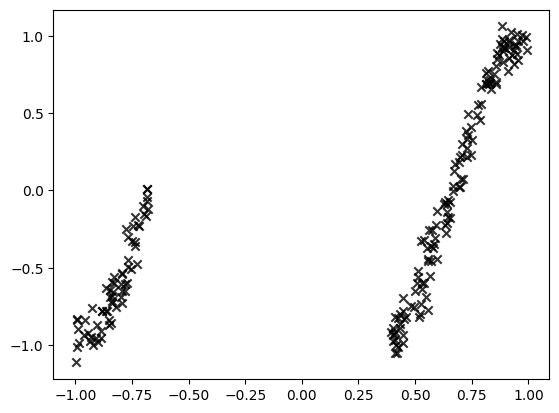

In [18]:
plt.scatter(X, Y, marker='x', color='k', alpha=0.8);

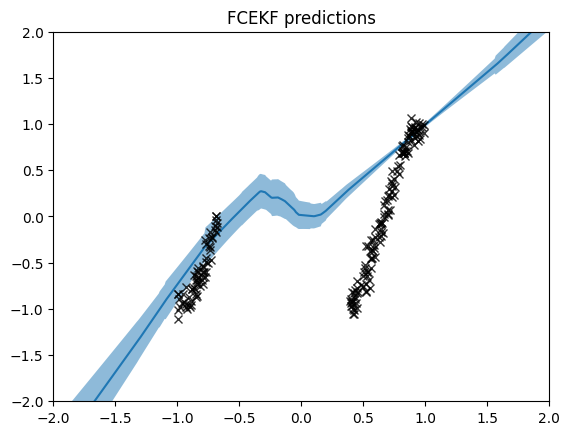

In [19]:
# FCEKF
plot_predictions(X, Y, X_grid, 1e-2, 1e-4, flat_params, apply_fn);

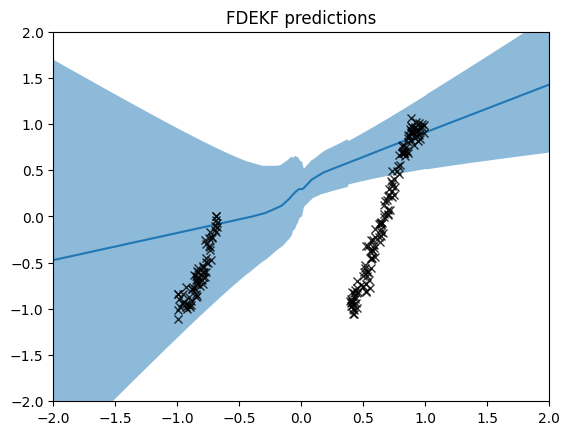

In [20]:
# FCEKF
plot_predictions(X, Y, X_grid, 1e-1, 1e-4, flat_params, apply_fn, 'fdekf');

In [21]:
# # VDEKF
# plot_predictions(X, Y, X_grid, 1.0, 1e-3, flat_params, apply_fn, 'vdekf');

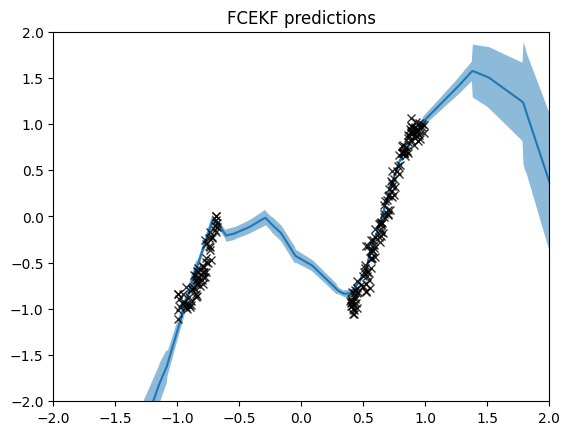

In [22]:
# FCEKF
plot_predictions(X_shuffled, Y_shuffled, X_grid, 1, 1e-4, flat_params, apply_fn);

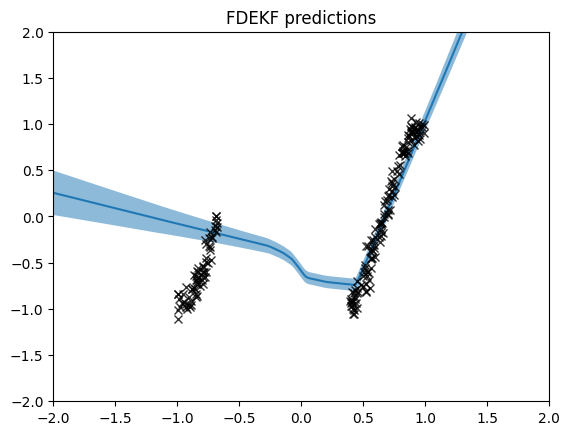

In [23]:
# FDEKF
plot_predictions(X_shuffled, Y_shuffled, X_grid, 1e-3, 1e-3, flat_params, apply_fn, 'fdekf');

# Prior Predictive Distribution

In [24]:
prior_mean, prior_cov = flat_params, jnp.eye(flat_params.size)*1e-2
pred_means, pred_covs = vmap(
    linearized_posterior_predictive_moments, (None, 0, None, None, None)
)(apply_fn, X_grid, prior_mean, prior_cov, 1e-4)
pred_means, pred_covs = pred_means.squeeze(), pred_covs.squeeze()

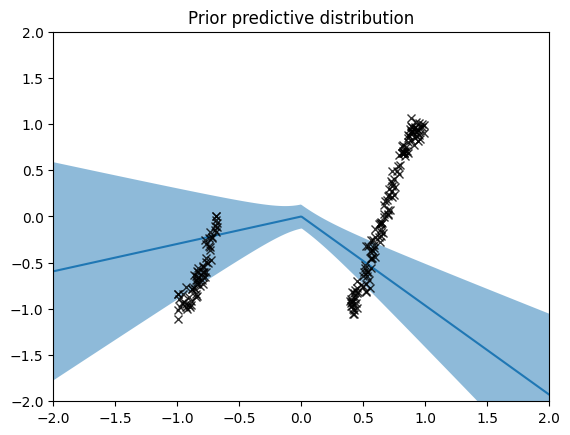

In [25]:
# Plot predictions
fig, ax = plt.subplots()
ax.plot(X_grid, pred_means, label='mean');
ax.plot(X, Y, 'kx', label='data', alpha=0.8);
ax.fill_between(X_grid.squeeze(), pred_means - 1.0 * jnp.sqrt(pred_covs), pred_means + 1.0 * jnp.sqrt(pred_covs), alpha=0.5, label='1 std');
ax.set_xlim(-2.0, 2.0)
ax.set_ylim(-2.0, 2.0)
ax.set_title(f'Prior predictive distribution');

# MLP Models

Shallow and Wide

In [43]:
# Define the MLP model
input_dim, hidden_dims, output_dim = 1, [200, 200,], 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)
print(flat_params.shape)

(40801,)


In [32]:
# Hyperparameter tuning
evaluate_fcekf = lambda initial_var, emission_var: evaluate_inference(
    flat_params, apply_fn, fcekf_inference, X_shuffled, Y_shuffled, X_shuffled, Y_shuffled, initial_var, emission_var
)
evaluate_fdekf = lambda initial_var, emission_var: evaluate_inference(
    flat_params, apply_fn, fdekf_inference, X_shuffled, Y_shuffled, X_shuffled, Y_shuffled, initial_var, emission_var
)
evaluate_vdekf = lambda initial_var, emission_var: evaluate_inference(
    flat_params, apply_fn, vdekf_inference, X_shuffled, Y_shuffled, X_shuffled, Y_shuffled, initial_var, emission_var
)

params_opt = {
    'initial_var': (1e-6, 5.0),
    'emission_var': (1e-6, 1.0)
}

# Tune FCEKF params
fdekf_optimizer = BayesianOptimization(evaluate_fdekf, params_opt, random_state=0)
fdekf_optimizer.maximize(init_points=25, n_iter=25)
print(fdekf_optimizer.max)

|   iter    |  target   | emissi... | initia... |
-------------------------------------------------
| 1         | -509.6    | 0.5488    | 3.576     |
| 2         | -691.4    | 0.6028    | 2.724     |
| 3         | -535.0    | 0.4237    | 3.229     |
| 4         | -598.8    | 0.4376    | 4.459     |
| 5         | -492.7    | 0.9637    | 1.917     |
| 6         | -516.4    | 0.7917    | 2.644     |
| 7         | -499.6    | 0.568     | 4.628     |
| 8         | -6.234e+0 | 0.07104   | 0.4356    |
| 9         | -7.426e+0 | 0.02022   | 4.163     |
| 10        | -625.6    | 0.7782    | 4.35      |
| 11        | -559.2    | 0.9786    | 3.996     |
| 12        | -721.1    | 0.4615    | 3.903     |
| 13        | -866.1    | 0.1183    | 3.2       |
| 14        | -1.738e+0 | 0.1434    | 4.723     |
| 15        | -514.6    | 0.5218    | 2.073     |
| 16        | -771.2    | 0.2646    | 3.871     |
| 17        | -519.7    | 0.4562    | 2.842     |
| 18        | -624.0    | 0.01879   | 3.088     |


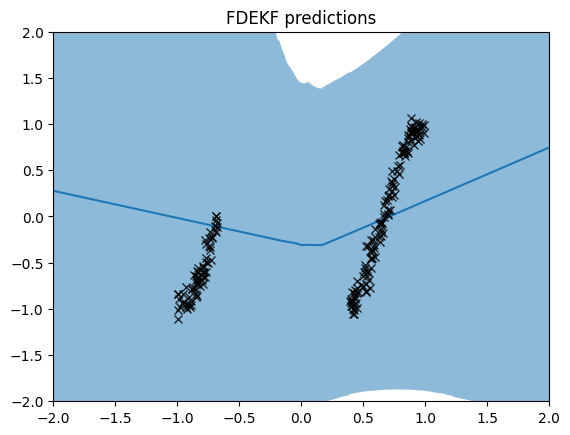

In [58]:
# FDEKF
plot_predictions(X_shuffled, Y_shuffled, X_grid, 0.3011282979208775, 0.697631498296069, flat_params, apply_fn, 'fdekf');

In [59]:
# Tune VDEKF params
vdekf_optimizer = BayesianOptimization(evaluate_vdekf, params_opt, random_state=0)
vdekf_optimizer.maximize(init_points=20, n_iter=20)
print(vdekf_optimizer.max)

|   iter    |  target   | emissi... | initia... |
-------------------------------------------------


KeyboardInterrupt: 

Deep and Narrow

In [37]:
# Define the MLP model
input_dim, hidden_dims, output_dim = 1, [20] * 15, 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)
print(flat_params.shape)

(5941,)


Deep and Wide

In [ ]:
# Define the MLP model
input_dim, hidden_dims, output_dim = 1, [100] * 10, 1
model_dims = [input_dim, *hidden_dims, output_dim]
_, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims)
print(flat_params.shape)